# Analysis on Air quality index in Hue, Vietnam.
## May 6, 2020
---

This is a quick analysis based on data acquired in Phu Xuan University (Hue, Vietnam), provided by Mr. Dam Quang Minh. The analysis helps to clarify some myths in Vietnam about the air quality linking with human activities.

## 1. Dataset description

- Data is acquired hourly from 2/1/2019 to 6/5/2020.

- Data includes total of 13 variables, in which 8 are the air quality index and concentration of some gases: AQI US, AQI CN, PM2.5, PM10, CO2, Temperature (C), Temperature (F) and Humidity (%).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/nhohung/datasciencecoursera/master/historical_hourly_data_GLRT9TR.csv', parse_dates=True)

In [4]:
df = df.iloc[:,1:10]
df.Datetime = pd.to_datetime(df.Datetime)
df.set_index('Datetime', inplace = True)

Part of the data looks like this:

In [16]:
df.head()

,AQI US,AQI CN,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
Datetime,,,,,,,,
2020-05-06 09:00:00,152,79,58,88,437.3,31.8,89.3,74.0
2020-05-06 08:00:00,153,80,59,87,445.8,30.4,86.7,78.8
2020-05-06 07:00:00,153,80,59,84,467.2,28.4,83.1,84.4
2020-05-06 06:00:00,152,77,57,73,492.0,26.9,80.4,88.3
2020-05-06 05:00:00,157,90,67,86,492.6,27.2,80.9,87.0


Air quality index (AQI) indicates how bad the quality is for human, the higher the worse. Since Vietnam has high density of population with extremely high usage of traffic vehicles, a large amount of people have some believes that I will be clarifying today:

- **Do particle matter PM10 and PM2.5 cause bad AQI?**

- **Is AQI bad during in weekdays when people use their vehicles to go to work?**

- **Does high humidity also cause bad AQI?**

- **Is there any relation between air quality and the tradition of burning ghost money (joss paper or votive)?**

## 2. Exploratory analysis

First we look at a crossplot between all pairs of parameters:

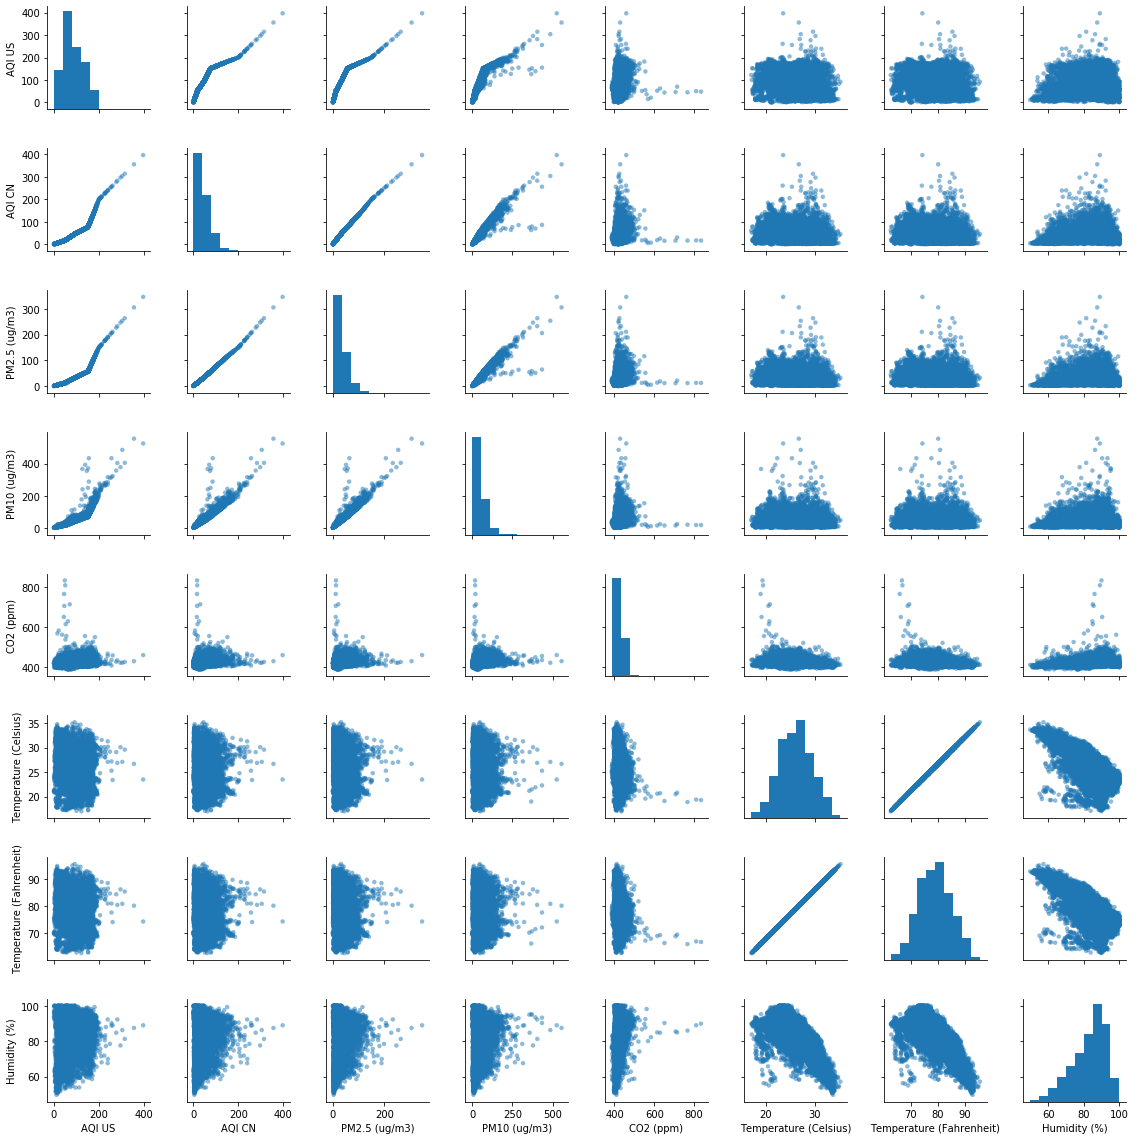

In [5]:
sns.pairplot(df, height=2, markers=".",
            plot_kws={'s':80, 'edgecolor':'none', 'alpha':0.5})

#### Observations:

- Temperature C and F are linear dependent, which makes sense because each can be calculated from the other.

- AQI CN (China) and QI US (U.S.A.) hasve different linear relations in different intervals, changes found at 200, and 100. They are equal above 200.

- PM 2.5 and PM10 seem to have high correlation to both AQI. Especially PM 2.5 has good linear indicator with AQI CN. PM10 has similar relationship to AQI US, just like AQI CN, however it has some outliers.

- There is week correlation between Temperature and Humidity.

- CO2, Temperature and Humidity do not seem to relate to AQI.

I also check the regularity of the samples measured each day. In the figure below, hot colors indicate finest number of hourly samples, while cold colors indicate some data missing:

In [17]:
a = df
a['Date'] = a.index.date
b = pd.DataFrame(df.groupby('Date').count().iloc[:,0])
b.reset_index(inplace=True)
a['Date'] = a['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
b['Date'] = b['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
c = a.merge(b, left_on='Date', right_on='Date', how='inner')
c.set_index(a.index, inplace=True)

In [18]:
def plot_colourline(x,y,c):
    c = cm.rainbow((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return

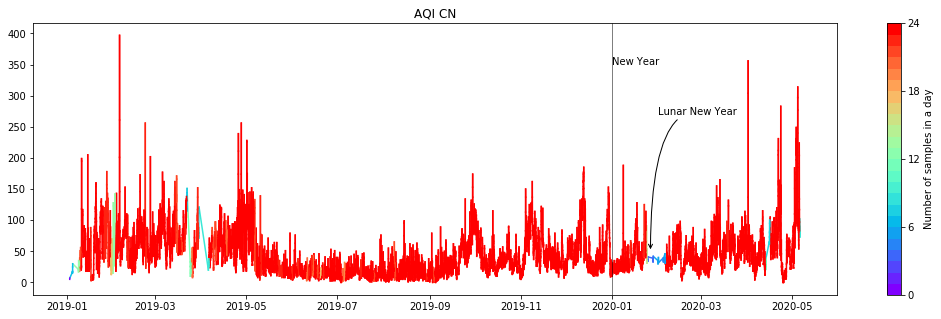

In [20]:
fig,ax = plt.subplots(figsize=(18,5))

x=c.index#[-700:]
y=c['AQI CN']#[-700:]
prop=c['AQI US_y']#[-700:]
ax = plot_colourline(x,y,prop)

plt.axvline(x='2020-01-01', linewidth = 0.5, color = 'k')
plt.annotate('New Year', xy=('2020-01-01', 350), xycoords='data')
plt.annotate('Lunar New Year', xy = ('2020-01-27', 50) , xycoords = 'data',
             xytext=('2020-02-01', 270), textcoords = 'data',
             arrowprops=dict(arrowstyle='->', connectionstyle = 'angle3, angleA=0,angleB=90'))

sm1=ScalarMappable(cmap=cm.get_cmap('rainbow',24))
sm1.set_array([0,24])
cbar= plt.colorbar(sm1, ticks=[0, 6, 12, 18, 24])
cbar.set_label('Number of samples in a day')

plt.title('AQI CN')
plt.xlabel('')

plt.show()

It can be seen that some days have less than half day recorded, especially on the Lunar New Year (February 2020). This indicates a holiday where no data is recored at this manual station. However since these missing data is relatively small compared to the total amount of samples, we can carry out our analysis.

## 3. Do particle matter PM10 and PM2.5 cause bad AQI?

According to the pair plot above, they seem to have correlation. If I run a linear regression predicting AQI CN from other variables after normalization, this is the result:

In [6]:
X = df[['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'CO2 (ppm)', 'Temperature (Celsius)', 'Humidity (%)']]
Y1 = df['AQI US']
Y2 = df['AQI CN']

In [7]:
x = X.values
normalized_x = preprocessing.MinMaxScaler().fit_transform(x)
normalized_X = pd.DataFrame(normalized_x)
normalized_X.columns = X.columns
normalized_X.set_index(X.index, inplace = True)

In [11]:
X1 = sm.add_constant(normalized_X)
model = sm.OLS(Y2, X1).fit()
predictions = model.predict(X1) 
print(model.summary())
print(model.pvalues)

                            OLS Regression Results                            
Dep. Variable:                 AQI CN   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.596e+05
Date:                Sun, 05 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:47:37   Log-Likelihood:                -20466.
No. Observations:               11012   AIC:                         4.094e+04
Df Residuals:                   11006   BIC:                         4.099e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.66

The high R-squarec value indicates a very good model, with the 2 PM concentrations have lowest p-value. However this may lead to a wrong conclusion that PM2.5 and PM 10 cause bad air quality.

If we look up the formula of AQI, it returns that AQI actually is piecewise linear calculated from some indicators including particle matter (PM2.5 and PM10). Reference [here](https://en.wikipedia.org/wiki/Air_quality_index).

With this fact, the question asking if high PM concentration causes bad air quality becomes a wrong question. We don't look for correlation because PM stays in the formula.

A deeper finding also found that AQI CN and AQI US are calculated differently. This [page](https://support.airvisual.com/en/articles/3029421) explains how they are identical for values above 200 (151ug/3 PM2.5 concentration) and how AQI US is higher than AQI CN when PM2.5 concentration is smaller than 151ug/3.

## 4. Is AQI bad during in weekdays when people use their vehicles to go to work?

People believe all CO2, particle matter and air quality index are higher in weekdays, but simple boxplots do not agree with that:

In [21]:
df['Weekday'] = df.index.weekday_name

In [22]:
t = df[['AQI CN', 'PM10 (ug/m3)', 'CO2 (ppm)', 'Weekday']]
t.loc[(t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday'), 'isweekend'] = 'Weekends'
t.loc[~((t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday')), 'isweekend'] = 'Weekdays' 

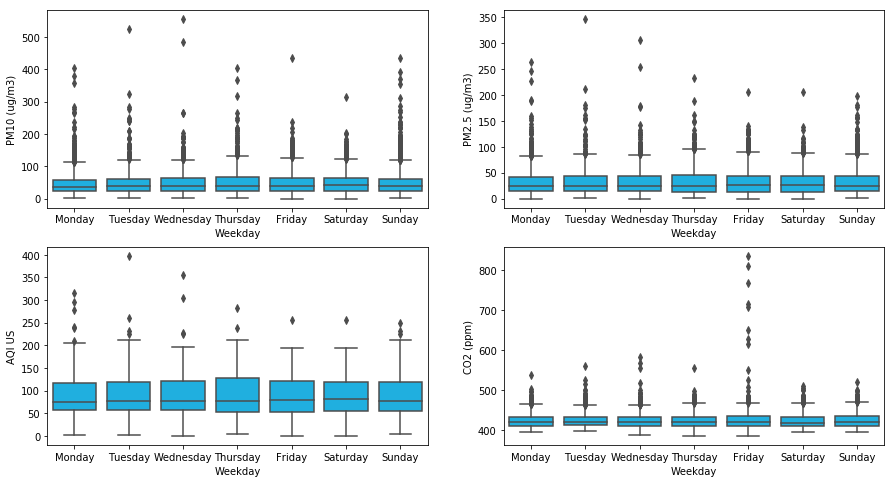

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
sns.boxplot(x="Weekday", y="PM10 (ug/m3)", data=df, color = 'deepskyblue',
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            ax=axs[0,0])
sns.boxplot(x="Weekday", y="PM2.5 (ug/m3)", data=df, color = 'deepskyblue',
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            ax=axs[0,1])
sns.boxplot(x="Weekday", y="AQI US", data=df, color = 'deepskyblue',
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            ax=axs[1,0])
sns.boxplot(x="Weekday", y='CO2 (ppm)', data=df, color = 'deepskyblue',
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            ax=axs[1,1])

However, when plotting the data with respect to hours in a day, there is an interesting trend:

In [24]:
df['Hour'] = df.index.hour

In [25]:
t = df[['AQI CN', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'CO2 (ppm)', 'Weekday', 'Hour', 'Temperature (Celsius)']]
t.loc[(t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday'), 'isweekend'] = 'Weekends' 
t.loc[~((t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday')), 'isweekend'] = 'Weekdays' 

In [26]:
df_wd = t[t.isweekend=='Weekdays']
df_wk = t[t.isweekend=='Weekends']

[(0, 100)]

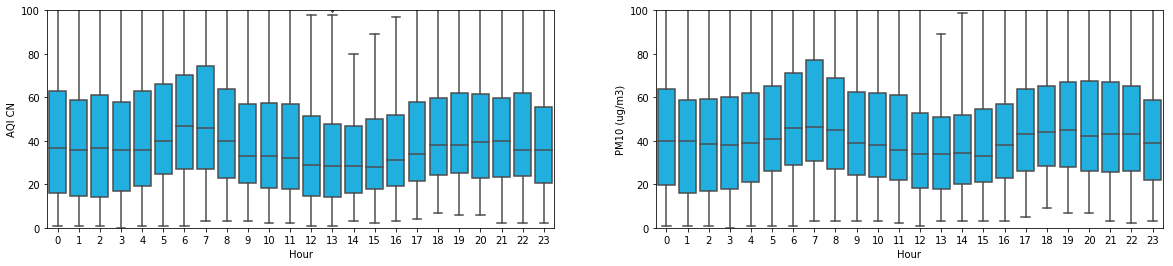

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 4))
sns.boxplot(x="Hour", y="AQI CN", data=df_wk, color = 'deepskyblue',
           ax=axs[0])
sns.boxplot(x="Hour", y="PM10 (ug/m3)", data=df_wk, color = 'deepskyblue',
           ax=axs[1])
axs[0].set(ylim = (0,100))
axs[1].set(ylim = (0,100))

It is shown here a potential link between vehicle usage with air quality. All AQI and PM are highest in the morning (6-7 AM) in the time when people go to work. They get high again in late afternoon around 5 PM, when people go home.

It is interesting that these parameters still stay high in the evening. Because the data is acquired in on-campus station, high index, assuming to relate to vehicles' exhause, may suggest some reasons:

- Classes in the afternoon are not off at the same time, but spread depending on the schedule.

- There might be night courses with lower students but still contribute to relatively high measure in the evening.

Just to confirm, I compare hourly data between weekends and weekdays. There is no difference between them:

(350, 500)

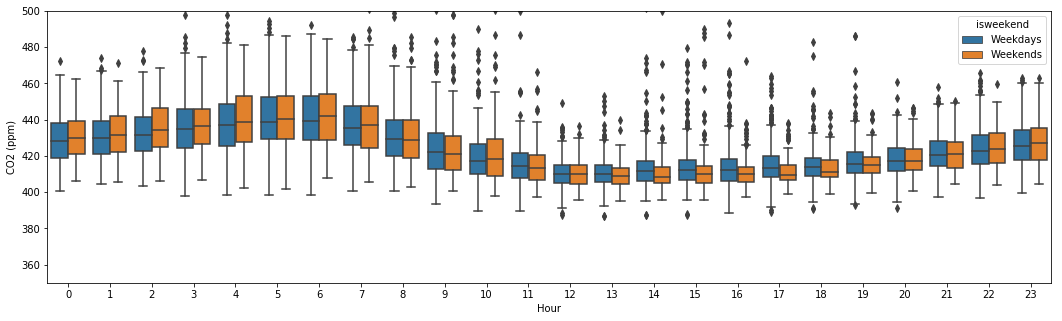

In [29]:
fig, ax = plt.subplots(figsize=(18,5))
ax = sns.boxplot(x="Hour", y="CO2 (ppm)", data=t, hue='isweekend')
plt.ylim([350,500])

## 5. Does high humidity also cause bad AQI?

In this section, I test two approaches:

- The first one builds a linear model predicting AQI CN from normalized CO2, Temperature and Humidity to find if there is any correlation to the three variables.

- The second one builds nonlinear model predicting the same relation, with transformation of both the target and the input variables.

### 5.1. Linear model

In [12]:
X = df[['CO2 (ppm)', 'Temperature (Celsius)', 'Humidity (%)']]
Y1 = df['AQI US']
Y2 = df['AQI CN']

In [13]:
x = X.values
normalized_x = preprocessing.MinMaxScaler().fit_transform(x)
normalized_X = pd.DataFrame(normalized_x)
normalized_X.columns = X.columns
normalized_X.set_index(X.index, inplace = True)

In [14]:
X1 = sm.add_constant(normalized_X)
model = sm.OLS(Y2, X1).fit()
predictions = model.predict(X1) 
print(model.summary())
print(model.pvalues)

                            OLS Regression Results                            
Dep. Variable:                 AQI CN   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     347.1
Date:                Sun, 05 Jul 2020   Prob (F-statistic):          2.32e-215
Time:                        16:08:07   Log-Likelihood:                -53444.
No. Observations:               11012   AIC:                         1.069e+05
Df Residuals:                   11008   BIC:                         1.069e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    25.24

First of all, the R-squared value is very low at 0.086. This indicates a poor model to predict AQI. Plus, this model has very large confidence interval, about 47 units for all 3 variables. Recall previous box plot, where the interquartile range is about 40 units, a CI of 47 unit suggests a noisy model.

In conclusion, in spite of very low p-value for all input variables (which imply statistical significant), the linear model suggests that humidity doesn't have any correlation with AQI.

### 5.2. Nonlinear prediction model

As observed from the pair plot, the distribution of all variables are skewed, in general. Therefore I applied transformation for both the input variables and the target to stablize the mode:

- 1 polynomial transformation and 2 trasnformations to normal distribution (Gaussian and quantile)

- 1 transformation to normal distribution (lograrithm transform)

Also I don't use simple linear regression because using high degree polynomial regression is prone to over fitting. To amend this, I use regularized linear regression. Between the two popular regularized approaches of Ridge and Lasso, I select Lasso because it uses L1 error, which is more stable than L2 from Rigde regression.

I am running a polynomial functions with maximum degrees of 7, and alpha of 0.01:

In [30]:
t = df[['AQI US', 'AQI CN', 'Humidity (%)', 'Temperature (Celsius)']]

In [31]:
X = t[['Humidity (%)', 'Temperature (Celsius)']]
Y2 = t['AQI CN']

In [32]:
x = X.values
normalized_x = preprocessing.MinMaxScaler().fit_transform(x)
normalized_X = pd.DataFrame(normalized_x)
normalized_X.columns = X.columns
normalized_X.set_index(X.index, inplace = True)

In [33]:
R2TransI = pd.DataFrame(columns=['LS','GL','QL'])

for i in range(1,8):
    poly=PolynomialFeatures(i)
    poly_X = poly.fit_transform(normalized_X)
    
    # linear reg
    regr = linear_model.LinearRegression().fit(poly_X, Y2)
    ypredLR = regr.predict(poly_X)
    
    # Lasso linear reg
    linlasso = Lasso(alpha=0.01).fit(poly_X, Y2)
    ypredLS = linlasso.predict(poly_X)
    
    # Gaussian transform
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    Gauss_X = pt.fit_transform(poly_X)
    Glinlasso = Lasso(alpha=0.01).fit(Gauss_X, Y2)
    ypredGL = Glinlasso.predict(Gauss_X)
    
    # quantile transform
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    quantile_X = qt.fit_transform(poly_X)
    
    Qlasso = Lasso(alpha=0.01).fit(quantile_X, Y2)
    ypredQL = Qlasso.predict(quantile_X)

    R2TransI = R2TransI.append({
                               'LS': r2_score(Y2, ypredLS),
                               'GL': r2_score(Y2, ypredGL),
                               'QL': r2_score(Y2, ypredQL),},
                              ignore_index=True)

In [34]:
Y2_trans = np.log1p(Y2)
R2TransO = pd.DataFrame(columns=['LS','GL','QL'])

for i in range(1,8):
    poly=PolynomialFeatures(i)
    poly_X = poly.fit_transform(normalized_X)
    
    # linear reg
    regr = linear_model.LinearRegression().fit(poly_X, Y2_trans)
    ypredLR = regr.predict(poly_X)
    
    # Lasso linear reg
    linlasso = Lasso(alpha=0.01).fit(poly_X, Y2_trans)
    ypredLS = linlasso.predict(poly_X)
    
    # Gaussian transform
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    Gauss_X = pt.fit_transform(poly_X)
    Glinlasso = Lasso(alpha=0.01).fit(Gauss_X, Y2_trans)
    ypredGL = Glinlasso.predict(Gauss_X)
    
    # quantile transform
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    quantile_X = qt.fit_transform(poly_X)
    
    Qlasso = Lasso(alpha=0.01).fit(quantile_X, Y2_trans)
    ypredQL = Qlasso.predict(quantile_X)
    
    R2TransO = R2TransO.append({
                               'LS': r2_score(np.log1p(Y2), ypredLS),
                               'GL': r2_score(np.log1p(Y2), ypredGL),
                               'QL': r2_score(np.log1p(Y2), ypredQL),},
                              ignore_index=True)

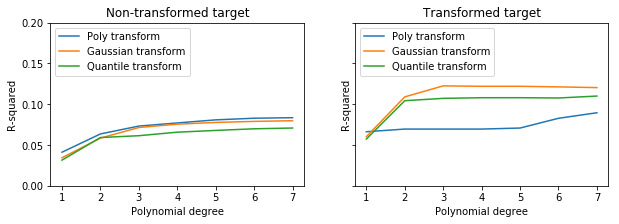

In [35]:
fig, ax = plt.subplots(ncols = 2, sharey=True, figsize=(10,3))

ax[0].plot(np.arange(1, 8), R2TransI)
ax[1].plot(np.arange(1, 8), R2TransO)

ax[0].set_xlabel('Polynomial degree')
ax[1].set_xlabel('Polynomial degree')
ax[0].set_ylabel('R-squared')
ax[1].set_ylabel('R-squared')

ax[0].set_yticks(np.arange(0, 0.25, step=0.05))
ax[1].set_yticks(np.arange(0, 0.25, step=0.05))
ax[0].legend(['Poly transform','Gaussian transform','Quantile transform'], loc=2)
ax[1].legend(['Poly transform','Gaussian transform','Quantile transform'], loc=2)

ax[0].title.set_text('Non-transformed target')
ax[1].title.set_text('Transformed target')

plt.show()

- In general, R-squared values are higher with transformed target, and with higher degree of the polynomial functions. In all cases, R-squared values are higher when a normalization transformation is applied.

- The results also show that R-squared values are saturated at degree 7. Using higher degree will not improve the model.

- In all cases, R-squared values are small (< 15%). This indicates humidity does not have correlation with AQI.

## 6. Is there any relation between air quality and the tradition of burning ghost money (joss paper or votive)?

This question is asked because of the local spiritual tradition. People normally burn joss paper (also called ghost money or votive) to the other world to be blessed. The occasions are the first and the middle days of the lunar months. Also in this city, people celebrate May 23 (lunar calendar) due to a historical event in 1885. The burning activity is normally carried out 2 days before the actual occasion.

Below I extract and plot 2 days around all first, middle days, and May 23. I then create box plots to compare these events with regular days:

In [38]:
t=df
t['date'] = t.index.date
t['date'] = t['date'].astype(str)

In [41]:
t['cung2'] = t['date'].apply(lambda x: 'First days' if x in ['2019-01-05',
                                                       '2019-02-04',
                                                       '2019-03-05',
                                                       '2019-04-04',
                                                       '2019-05-04',
                                                       '2019-06-02',
                                                       '2019-07-02',
                                                       '2019-07-31',
                                                       '2019-08-29',
                                                       '2019-09-28',
                                                       '2019-10-27',
                                                       '2019-11-25',
                                                       '2019-12-25',
                                                       '2020-02-22',
                                                       '2020-03-23',
                                                       '2020-04-22'] else ('Middle days' if x in ['2019-01-19',
                                                                                          '2019-02-18',
                                                                                          '2019-03-19',
                                                                                          '2019-04-18',
                                                                                          '2019-05-18',
                                                                                          '2019-06-16',
                                                                                          '2019-07-16',
                                                                                          '2019-08-14',
                                                                                          '2019-09-12',
                                                                                          '2019-10-12',
                                                                                          '2019-11-10',
                                                                                          '2019-12-09',
                                                                                          '2020-01-08',
                                                                                          '2020-02-07',
                                                                                          '2020-03-07',
                                                                                          '2020-04-06',
                                                                                         ] else ('23/5' if x in ['2019-06-24', '2019-06-23'] else 'Regular days')))

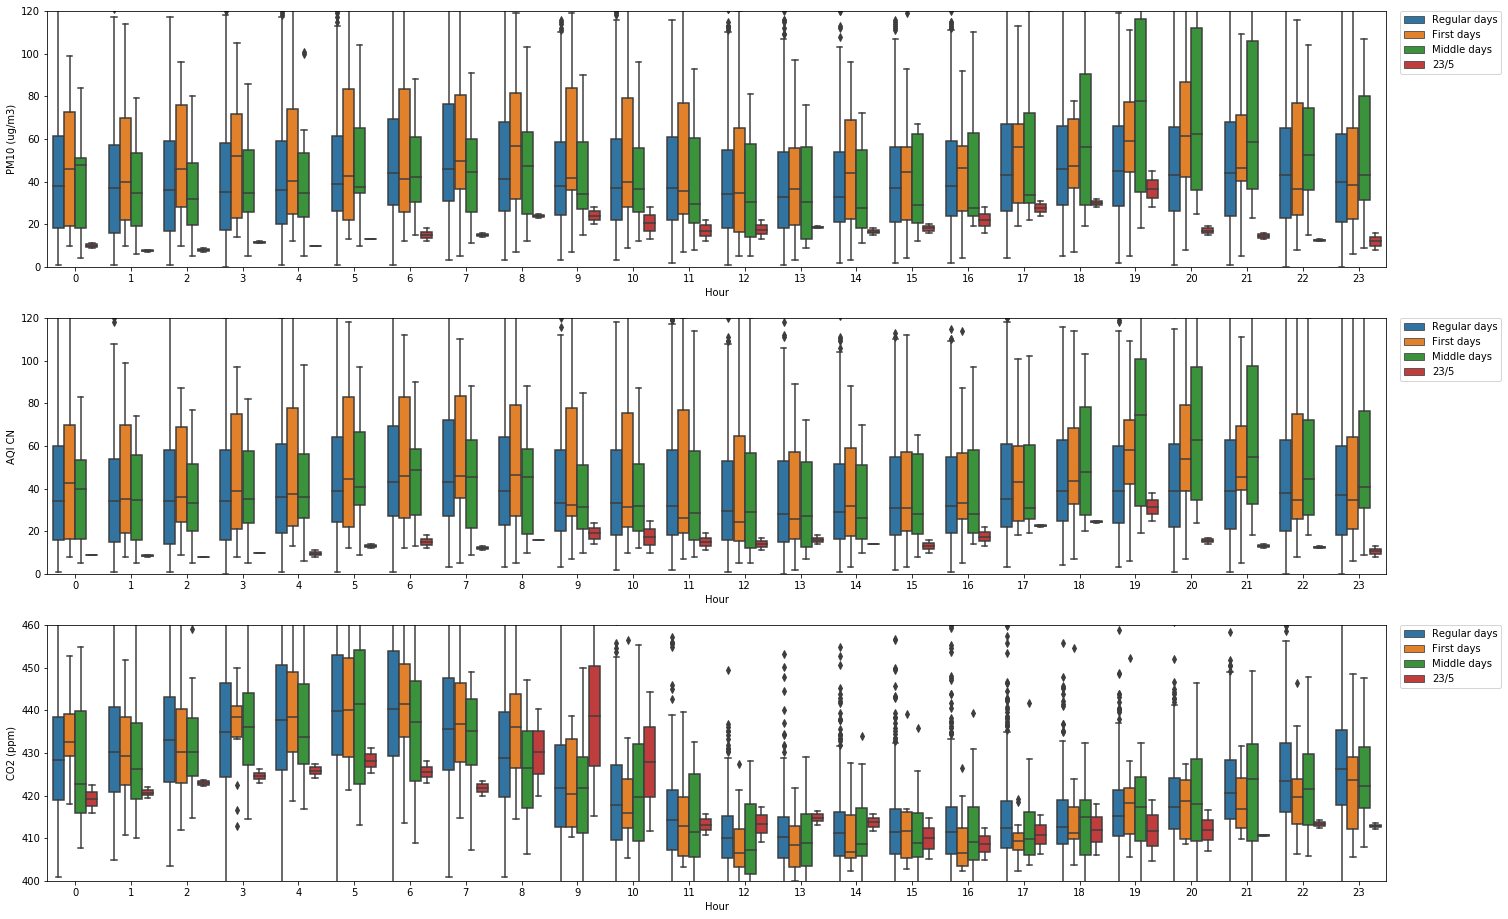

In [44]:
fig, axs = plt.subplots(nrows = 3, figsize=(24,16))
sns.boxplot(x="Hour", y="PM10 (ug/m3)", data=t, hue='cung2', ax=axs[0])
sns.boxplot(x="Hour", y="AQI CN", data=t, hue='cung2', ax=axs[1])
sns.boxplot(x="Hour", y="CO2 (ppm)", data=t, hue='cung2', ax=axs[2])

axs[0].set_ylim(0,120)
axs[1].set_ylim(0,120)
axs[2].set_ylim(400,460)

axs[0].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axs[1].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axs[2].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.show()

Features of 23/5:

- High CO2 from 9-10 AM, then stay normal to 8 PM

- Otherwise, other parameters are lower than normal days

Features of first days:

- AQI and PM higher than regular days, particularly in the morning and in the evening from 6-9 PM. The only time intervals that these parameters are similar to regular days are 1-5 PM and after 10 PM.

- There is no thing noticeable on CO2.

Features of middle days:

- AQI and PM are higher in 6-9 PM, otherwises similar to regular days

- There is no thing noticeable on CO2.

**From these observations, we can infer some statements:**

- There are some evidences indicating this spiritual activity is reflected in air quality parameters.

- There are clear differences between the three occasions: people tend to burn ghost money in the morning on the first days, in the evening on the middle days and at 9 AM (time for the historical event).

## 7. Conclusions

- Looking at the data in different time scale reveals useful information that is affected by overlooking or misunderstanding. To obtain a meaningful from this information, analysis process requires knowledge of nature, social activity, culture, history.

- Please note the findings are correct with this data, at this local station, and can be used as a reference, not to infer to other areas.